In [1]:
# demo de-noising using fhmm
# this was attempt 1, all is working but need to streamline so that
# it's simpler to run lots of tests

import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/final/tests', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
import librosa
import torchaudio
import numpy as np
import config
import os.path
import math
import os
import pathlib
import random
import torch
import utils
import warnings
import my_torch.torchio as tio
import torchaudio.functional as F
import torchaudio.transforms as T

In [3]:
from whale.setup import get_data, constants, annotations
import importlib
importlib.reload(constants)

importlib.reload(get_data)
from final import useful
importlib.reload(useful)

HUMPBACK = 'humpback'
BOWHEAD = 'bowhead'
NOISE = 'noise'

# constants for fe and what not
fs = 4000
nfft = 256

signal_types = [HUMPBACK, BOWHEAD, NOISE]

# type to label
signal_types_labels = {
    HUMPBACK: 0,
    BOWHEAD: 1,
    NOISE: 2
}

# label to type
label_to_type = {
    0: HUMPBACK,
    1: BOWHEAD,
    2: NOISE
}

get_data_dict = {
    HUMPBACK: [get_data.GetDataSimple(constants.HUMPBACK_WAV_A,constants.SWOOPS_LABELS_A, fs, useful.file_to_audio)],
    BOWHEAD: [get_data.GetDataSimple(constants.BOWHEAD_AUDIO,constants.BOWHEAD_LABELS_WHALE, fs, useful.file_to_audio)],
    NOISE: [get_data.GetDataSimple(constants.HUMPBACK_WAV_A,constants.HUMPBACK_LABEL_A_NOISE, fs, useful.file_to_audio),
            get_data.GetDataSimple(constants.BOWHEAD_AUDIO,constants.BOWHEAD_LABELS_NOISE, fs, useful.file_to_audio)]
}

samples, labels = useful.get_samples(get_data_dict, signal_types, signal_types_labels)


__collected samples__
humpback :  18
bowhead :  34
noise :  62


In [4]:
# separate using cross-validation
import final.cross_validation as cv
from final.cross_validation import *
import importlib
importlib.reload(cv)

n_folds = 2
cv_output = cv.split_data_for_cross_validation(samples, labels, n_folds, test_ratio=0.2)

In [5]:
cv_index = 0    # select train and test for this iteration
importlib.reload(useful)
train = useful.SampleHolder(cv_output[TRAIN_DATA][cv_index], cv_output[TRAIN_LABEL][cv_index])
val = useful.SampleHolder(cv_output[VAL_DATA][cv_index], cv_output[VAL_LABEL][cv_index])
test = useful.SampleHolder(cv_output[TEST_DATA], cv_output[TEST_LABEL])


In [6]:
# average power for each label
import noisey

def show_avg_powers(list_of_labels, sample_holder):
    for lab in list_of_labels:
        indices = sample_holder.sample_labels == lab
        samps = [item for item, condition in zip(sample_holder.samples, indices) if condition]
        avg_power = noisey.get_signal_avg_db(np.concatenate(samps))
        avg_power_v2 = utils.get_average_power(np.concatenate(samps), use_buffer=True)
        print('label: ', lab, ' | avg power: ', avg_power, ' | v2: ',  10 * np.log10(avg_power_v2))

show_avg_powers(np.array([0,1,2]), val)

label:  0  | avg power:  -16.738721132278442  | v2:  -16.752148418946433
label:  1  | avg power:  -16.681978702545166  | v2:  -16.68643039553295
label:  2  | avg power:  -31.009111404418945  | v2:  -31.01650031406159


In [7]:
# save pickle for else where
# import pickle
# print("Writing to pickle file: " + 'train-test-val' + ".pkl")
# output = open('train-test-val' + ".pkl", "wb")
# pickle.dump({'train': train, 'val':val, 'test':test}, output)
# output.close()

In [8]:
def get_mfcc_feature(sample, fs, nfft):
    return librosa.feature.mfcc(y=sample,sr=fs,n_mfcc=13,kwargs={'nfft': nfft})

In [9]:
def get_feature(samp):
    # add optionals here if needed
    # mfcc
    # feat = librosa.feature.mfcc(y=samp,sr=4000,n_mfcc=13).T
    feat = useful.get_log_power_feature(samp, nfft=256)
    return feat

# Train

In [10]:
# train hmms
from hmmlearn.hmm import GaussianHMM

hmms = {
    HUMPBACK: GaussianHMM(10),
    BOWHEAD: GaussianHMM(8),
    NOISE: GaussianHMM(5)
}

train.features = []
for sample in train.samples:
    train.features.append(get_feature(sample))

for key in hmms:
    cur_hmm = hmms[key]
    feat_indicis = train.sample_labels == signal_types_labels[key]
    hmm_features = [item for item, condition in zip(train.features, feat_indicis) if condition]
    cur_hmm.fit(np.concatenate(hmm_features))

# replace with hdp-hmms

In [11]:
# check / update hmms
importlib.reload(useful)
print(useful.find_similar_states_kl(hmms[BOWHEAD], hmms[NOISE]))

KeyboardInterrupt: 

In [56]:
hmm_bowhead_updated = useful.delete_component(hmms[BOWHEAD], 0)
print(useful.find_similar_states_kl(hmm_bowhead_updated, hmms[NOISE]))
hmms[BOWHEAD] = hmm_bowhead_updated

deleting comp 0
[[407.45930805  78.34849728  73.99750692  80.15983871  63.9705816 ]
 [278.40413394  36.45705188  53.50281185  37.59737055  53.83427319]
 [275.17389621  44.18396583  53.99056     44.7059541   56.94231898]
 [400.52026267  84.87605091  88.92112892  79.85931171  77.61467682]
 [336.68529499  62.22731563  82.42206868  70.02105033  86.55307315]
 [265.80826516  32.44153276  46.59125361  40.66734736  43.69799954]
 [315.47019308  65.61619467  84.51277357  55.04710986  50.41804659]]


In [70]:
print(useful.find_similar_states_kl(hmms[HUMPBACK], hmms[NOISE]))

[[ 96.00712725 165.51701799 249.02283001 657.96661218 351.74177273]
 [113.03195539 171.61765114 276.63012668 763.76894583 405.70404903]
 [213.7292389  167.98910426 223.29969659 503.41117698 276.46504411]
 [353.04403196 166.06956534 205.78775329 507.80905466 264.67915725]
 [180.93484962 136.81718192 195.5979357  451.0625468  241.58039216]
 [ 68.08115756 143.21418107 233.52811069 630.34587588 340.64327992]
 [ 18.38193184 174.82705575 287.88907542 750.47281522 414.19111706]
 [216.91754907 156.24514025 219.74196803 413.36792587 254.74067729]
 [266.35402995 181.22701424 241.52951607 532.13092302 291.09682177]
 [228.93946906 135.4294188  186.6754053  449.04219627 239.05035513]]


In [71]:
hmm_humpback_updated = useful.delete_component(hmms[HUMPBACK], 6)
print(useful.find_similar_states_kl(hmm_humpback_updated, hmms[NOISE]))
hmms[HUMPBACK] = hmm_humpback_updated

deleting comp 6
[[ 96.01801298 165.55941259 248.24577919 658.59280681 352.0535484 ]
 [112.87189365 170.97727886 276.58141747 769.15666811 404.97291899]
 [213.6785026  167.61513843 223.32597724 504.50840996 276.8024001 ]
 [353.29358818 165.44913936 205.86164508 506.2045544  264.70098866]
 [181.02107022 136.83312842 195.43659102 450.38830375 241.92610768]
 [ 68.04173669 143.15036547 233.3146945  629.70538433 339.05793109]
 [216.88883807 156.22144286 219.24846925 413.30556702 254.72348818]
 [266.31511402 181.15770508 241.49674295 531.26695429 291.70287826]
 [228.55419301 135.49350213 187.15283612 446.1871963  238.59714972]]


In [72]:
# get accuracy measure then decode combine
import sklearn.metrics
import decode_combine as dc
importlib.reload(dc)
combined_model = dc.DecodeCombineGaussian([hmm for hmm in hmms.values()])

## Validation

In [73]:
# if validate has added noise or reverb add here

import noisey
import matplotlib.pyplot as plt
importlib.reload(noisey)

signal_avg_db = -16 # from inspection

def get_noise_for_sample(sig_db, sample, snr_1=30, snr_2=30, snr_3=30):
    noise_power_1 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_1)
    noise_power_2 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_2)
    noise_power_3 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_3)

    noise_sample, _ = noisey.generate_gaussian_noise(len(sample), noise_power_1, noise_power_2, noise_power_3)
    return noise_sample

# noise_example = add_noise_to_sample(signal_avg_db, samples[0])
# plt.plot(noise_example)
# plt.plot(samples[0])
# plt.show()
# noisey.get_signal_avg_db(noise_example)
# noisey.get_signal_avg_db(samples[5])
# def add_noise_to_sample(sample):

In [114]:
importlib.reload(useful)
val.features = []
noise_samples = []
noise_features = []
noise_features_v2 = []
for i in range(len(val.samples)):

    # ---- noise / reverb adjustments ---- START
    noise_sample = get_noise_for_sample(signal_avg_db, val.samples[i], 10, 40, 40)
    noise_samples.append(noise_sample)
    noise_features.append(get_feature(noise_sample))

    adjusted_sample = val.samples[i] + noise_sample

    if val.sample_labels[i] == 2:
        noise_features_v2.append(get_feature(adjusted_sample))
    # ---- noise / reverb adjustments ---- END

    feature = get_feature(adjusted_sample)
    val.features.append(feature)
val.update_feature_labels()

In [115]:
_, val_pred, val_log_prob = combined_model.decode_hmmlearn(np.concatenate(val.features))
accuracy = useful.perf_measure(np.concatenate(val.feature_labels), val_pred)
print(accuracy)
# {'acc': 0.8788552375659906, 'tpr': 0.992887029288703, 'fpr': 0.3465674110835401}      | 30 db snr
# {'acc': 0.37735085945399394, 'tpr': 0.2629573170731707, 'fpr': 0.17641228939544104}   | 10 db snr

{'ACC': 0.6767608793180798, 'TPR': 0.6361840248377082, 'FPR': 0.16612021857923498, 'TNR': 0.833879781420765, 'PPV': 0.9368246051537822, 'NPV': 0.37183235867446396, 'FNR': 0.36381597516229186, 'FDR': 0.06317539484621779}


In [116]:
# optional create FHMM's
noise_hmm = GaussianHMM(3, covariance_type='diag', init_params='')
noise_hmm.fit(np.concatenate(noise_features))

noise_hmm_v2 = GaussianHMM(6, covariance_type='diag', init_params='')
noise_hmm_v2.fit(np.concatenate(noise_features_v2))

GaussianHMM(init_params='', n_components=6)

In [110]:
useful.find_similar_states_kl(noise_hmm_v2, hmms[NOISE])

array([[316.14148725, 160.8463426 , 193.89740918, 450.49948498,
        216.65986291],
       [637.43828116, 248.20232164, 221.82710412, 258.27738773,
        159.37671167],
       [404.89145651, 118.89900775, 107.77996769,  88.81506634,
         65.93289812],
       [ 20.93623941, 212.17256936, 333.52396796, 890.2197542 ,
        465.39348643],
       [173.13141238,  20.77562339,  30.85990398,  16.16424785,
         23.80559446],
       [151.98203434,  10.95337743,  26.82818845,   2.09988137,
         28.04969906]])

In [117]:
from final.models.fhmm import FactorialHMM

fhmms = {}
for key in hmms:
    fhmm = FactorialHMM(hmms[key], noise_hmm_v2)
    fhmms[key] = fhmm.hmm

combined_model_fhmm = dc.DecodeCombineGaussian([fhmm for fhmm in fhmms.values()])

_, val_pred_fhmm, val_log_prob_fhmm = combined_model_fhmm.decode_hmmlearn(np.concatenate(val.features))
accuracy = useful.perf_measure(np.concatenate(val.feature_labels), val_pred_fhmm)
print(accuracy)

# TEST 1: get_noise_for_sample(signal_avg_db, val.samples[i], 10, 10, 15)
# A - just noise
# {'ACC': 0.9009556907037359, 'TPR': 0.8855098389982111, 'FPR': 0.03343465045592705, 'TNR': 0.9665653495440729, 'PPV': 0.9911894273127754, 'NPV': 0.6652719665271967, 'FNR': 0.11449016100178891, 'FDR': 0.00881057268722467}
# B
# {'ACC': 0.838257691136156, 'TPR': 0.8043478260869565, 'FPR': 0.014634146341463415, 'TNR': 0.9853658536585366, 'PPV': 0.9958236658932714, 'NPV': 0.5372340425531915, 'FNR': 0.1956521739130435, 'FDR': 0.004176334106728539}

# A: {'ACC': 0.9380656108597285, 'TPR': 0.939318665720369, 'FPR': 0.06685236768802229, 'TNR': 0.9331476323119777, 'PPV': 0.9821892393320965, 'NPV': 0.7966706302021404, 'FNR': 0.06068133427963095, 'FDR': 0.017810760667903526}

# B



{'ACC': 0.9015795868772782, 'TPR': 0.8777142857142857, 'FPR': 0.004497751124437781, 'TNR': 0.9955022488755623, 'PPV': 0.9986996098829649, 'NPV': 0.6741116751269035, 'FNR': 0.12228571428571429, 'FDR': 0.0013003901170351106}


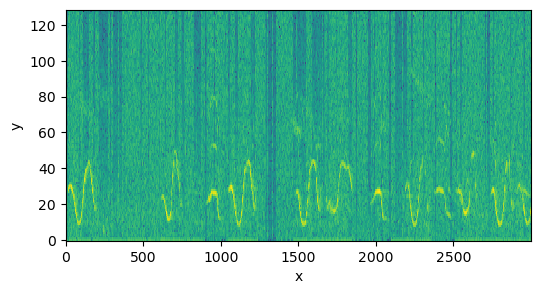

In [78]:
useful.vis_helper(np.concatenate(val.features)[:3000])

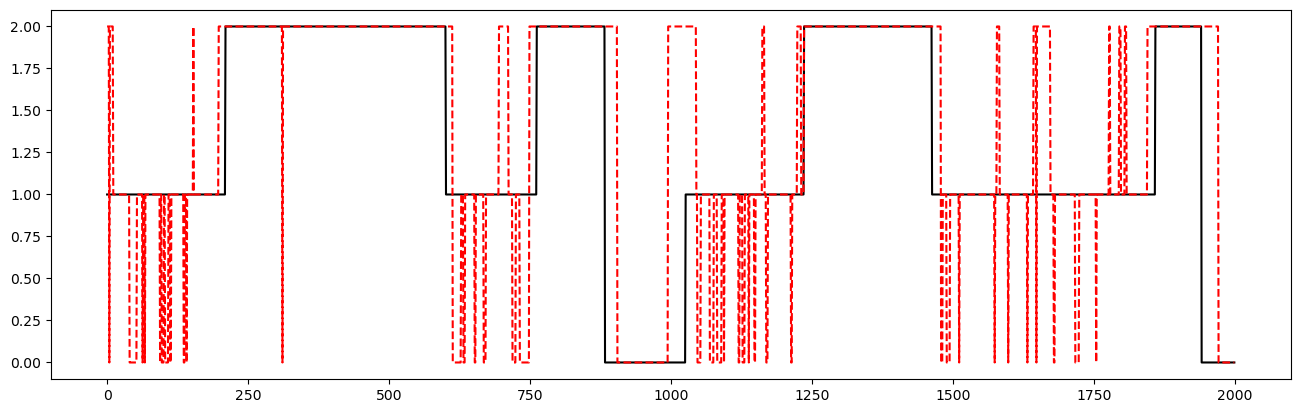

In [100]:
# val subset

val_true_subset = np.concatenate(val.feature_labels)[:2000]
val_pred_subset = val_pred_fhmm[:2000]
val_features_subset = np.concatenate(val.features)[:2000]

import matplotlib.pyplot as plt
plt.plot(val_true_subset, c='black')
plt.plot(val_pred_subset, '--', c='red')
# useful.vis_helper(val_features_subset)

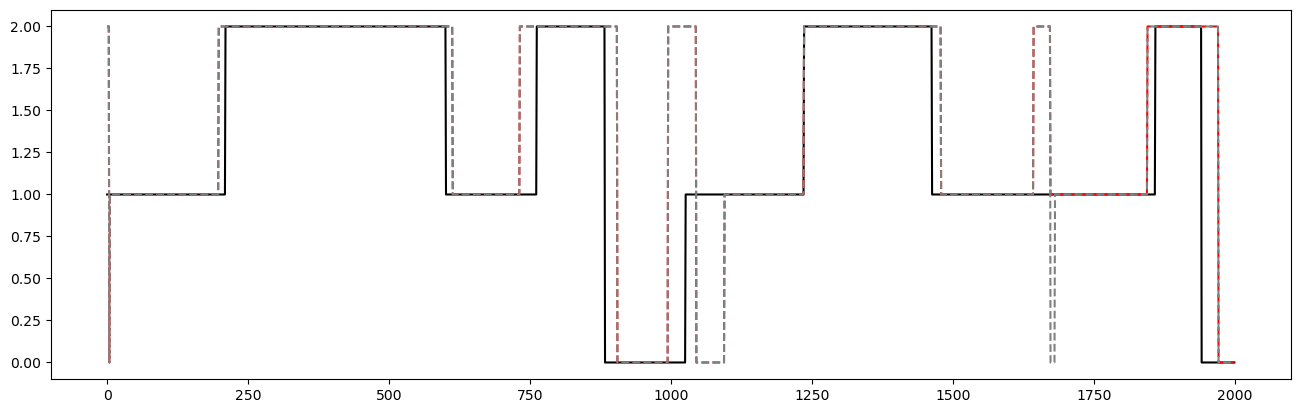

In [101]:
importlib.reload(useful)

val_pred_subset_smoothed = useful.smooth_labels(val_pred_subset)
plt.plot(val_true_subset, c='black')
plt.plot(useful.smooth_labels(val_pred_subset_smoothed), '--', c='red')
plt.plot(val_pred_subset_smoothed, '--', c='grey')

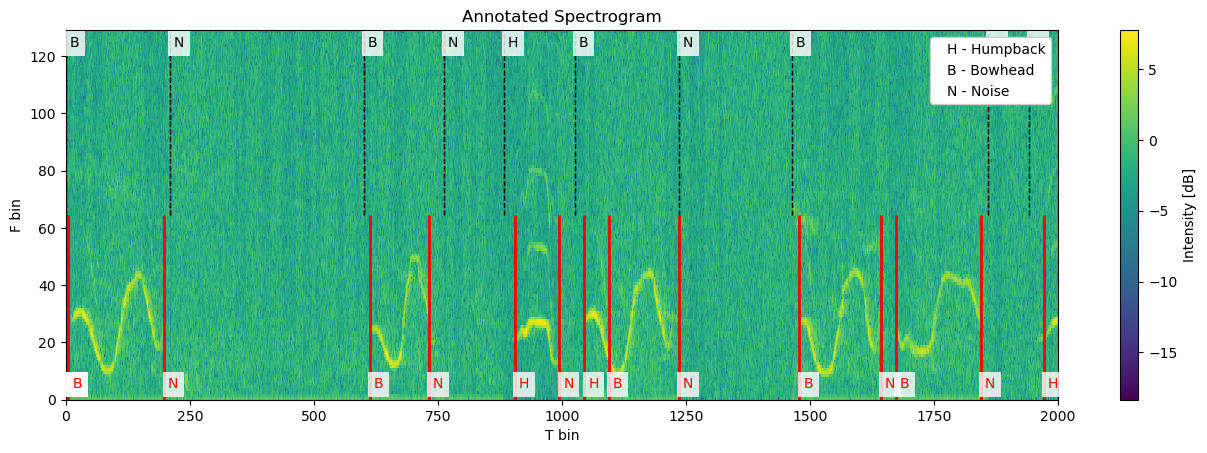

In [102]:
label_to_abr = {
    0: 'H',
    1: 'B',
    2: 'N'
}

useful.plot_spectrogram(val_features_subset, val_true_subset, useful.smooth_labels(val_pred_subset_smoothed), label_to_type, label_to_abr)

# Testing

In [122]:
# adjustment for sliding windows and noise introduction

importlib.reload(useful)

train_noise_indices = train.sample_labels == signal_types_labels['noise']
train_noise_samples = [item for item, condition in zip(train.samples, train_noise_indices) if condition]

# adjust samples so that there are more noise samples, and in the middle there is a long break
new_test_labels = []
new_test_samples = []

for i in range(len(test.samples)):
    new_test_samples.append(test.samples[i])
    new_test_labels.append(test.sample_labels[i])
    if int(test.sample_labels[i]) is not signal_types_labels['noise']:
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_labels.append(signal_types_labels['noise'])
        new_test_labels.append(signal_types_labels['noise'])
    if i == len(test.samples) // 2:
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_labels.append(signal_types_labels['noise'])
        new_test_labels.append(signal_types_labels['noise'])
        new_test_labels.append(signal_types_labels['noise'])
        new_test_labels.append(signal_types_labels['noise'])
        new_test_labels.append(signal_types_labels['noise'])
        new_test_labels.append(signal_types_labels['noise'])
        new_test_labels.append(signal_types_labels['noise'])
        new_test_labels.append(signal_types_labels['noise'])

test_new = useful.SampleHolder(new_test_samples, [int(num) for num in new_test_labels])

In [140]:
test_new.features = []
test_noise_samples = []
test_noise_features = []

for i in range(len(test_new.samples)):
    if i < len(test_new.samples) // 2:
        # ---- noise / reverb adjustments ---- START
        noise_sample = get_noise_for_sample(signal_avg_db, test_new.samples[i], 30, 30, 30)
        test_noise_samples.append(noise_sample)
        test_noise_features.append(get_feature(noise_sample))
        adjusted_sample = test_new.samples[i] + noise_sample
        # ---- noise / reverb adjustments ---- END
        feature = get_feature(adjusted_sample)
    else:
        # ---- noise / reverb adjustments ---- START
        noise_sample = get_noise_for_sample(signal_avg_db, test_new.samples[i], 5, 5, 30)
        # test_noise_samples.append(noise_sample)
        # test_noise_features.append(get_feature(noise_sample))
        adjusted_sample = test_new.samples[i] + noise_sample
        # ---- noise / reverb adjustments ---- END
        feature = get_feature(adjusted_sample)
    test_new.features.append(feature)
test_new.update_feature_labels()

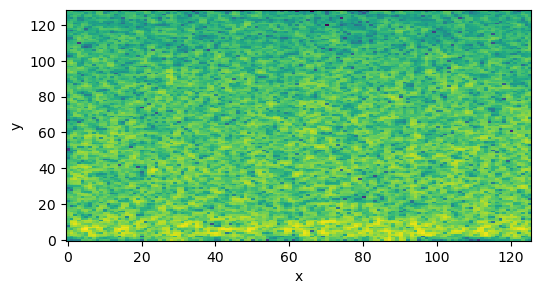

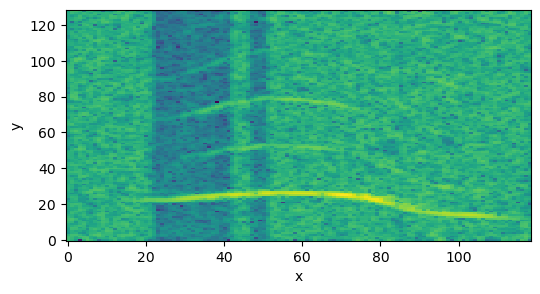

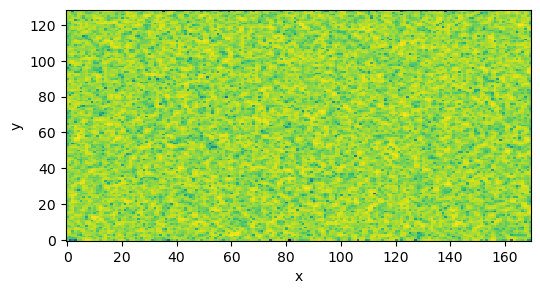

In [141]:
useful.vis_helper(train.features[5])
useful.vis_helper(test_new.features[-3])
useful.vis_helper(test_noise_features[0])

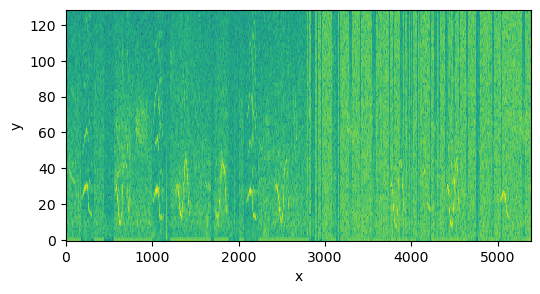

{'ACC': 0.46375902102290556, 'TPR': 0.3121363258520366, 'FPR': 0.06914212548015365, 'TNR': 0.9308578745198464, 'PPV': 0.9329192546583851, 'NPV': 0.3052057094878254, 'FNR': 0.6878636741479635, 'FDR': 0.0670807453416149}


In [142]:
test_features_concat = np.concatenate(test_new.features)
_, test_pred, test_log_prob = combined_model.decode_hmmlearn(test_features_concat)
useful.vis_helper(test_features_concat)
accuracy = useful.perf_measure(np.concatenate(test_new.feature_labels), test_pred)
print(accuracy)
## use fhmm_dc from above trained on noise as well

In [143]:
noise_hmm = GaussianHMM(3, covariance_type='diag', init_params='')
noise_hmm.fit(np.concatenate(test_noise_features))

fhmms = {}
for key in hmms:
    fhmm = FactorialHMM(hmms[key], noise_hmm)
    fhmms[key] = fhmm.hmm

combined_model_fhmm = dc.DecodeCombineGaussian([fhmm for fhmm in fhmms.values()])

_, val_pred_fhmm, val_log_prob_fhmm = combined_model_fhmm.decode_hmmlearn(np.concatenate(test_new.features)[3000:])
accuracy = useful.perf_measure(np.concatenate(test_new.feature_labels)[3000:], val_pred_fhmm)
print(accuracy)

{'ACC': 0.21232522009321594, 'TPR': 0.06920199501246883, 'FPR': 0.0856269113149847, 'TNR': 0.9143730886850153, 'PPV': 0.7985611510791367, 'NPV': 0.16685267857142858, 'FNR': 0.9307980049875312, 'FDR': 0.2014388489208633}


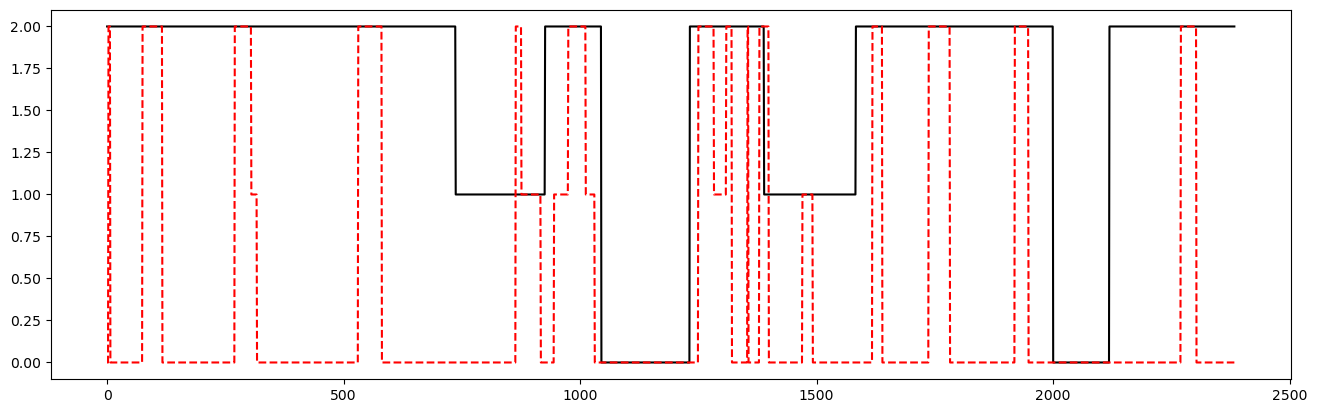

In [144]:
plt.plot(np.concatenate(test_new.feature_labels)[3000:], c='black')
plt.plot(useful.smooth_labels(val_pred_fhmm), '--', c='red')

In [145]:
# insert for adaptive noise handling
# update noise hmm to bayesian / HDP ?

class NoiseAdaptiveHMM:
    def __init__(self, dc_model: dc.DecodeCombineGaussian, signal_hmms, n_hmm: GaussianHMM):
        self.dc_model: dc.DecodeCombineGaussian = dc_model
        self.signal_hmms = signal_hmms  # dict with hmms inside
        self.n_hmm = n_hmm

    def update_model(self, new_noise_features):
        # new noise features, aim is to update fhmms and then dc_model
        self.n_hmm.fit(new_noise_features)

        temp = useful.find_similar_states_kl(self.n_hmm, hmms[NOISE])

        updated_fhmms = {}
        for key in self.signal_hmms:
            updated_fhmm = FactorialHMM(hmms[key], self.n_hmm)
            updated_fhmms[key] = updated_fhmm.hmm

        self.dc_model = dc.DecodeCombineGaussian([u_fhmm for u_fhmm in updated_fhmms.values()])

        print('model updated to changing noise conditions')


def sliding_windows(data, window_size, step_size, na_hmm: NoiseAdaptiveHMM, mean_log_prob, threshold = 1.2, re_train_buffer=10):
    output = {
        'noise_data': []
    }
    windows = []
    log_probs = []
    std_probs = []
    states_decoded = np.zeros(len(data))
    window_indices = []

    train_counter = 0

    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i+window_size, :]

        # do stuff here
        _, test_pred, log_prob = na_hmm.dc_model.decode_hmmlearn(window)
        log_probs.append(log_prob)
        states_decoded[i:i+window_size] = test_pred
        windows.append(window)
        window_indices.append(i)
        std_probs.append(np.std(log_probs[-3:]))

        # avoid re-training a lot
        if train_counter > 0:
            train_counter -= 1

        # if likelihood drops bellow threshold then re-train noise hmm and update other hmms
        # maybe don't compare to complete std mean here ?
        if np.mean(log_probs[-10:]) < mean_log_prob * threshold and std_probs[-1] < np.mean(std_probs) and train_counter == 0:
            # use last 3 windows to train noise hmm
            # data[i:i + (step_size * 3)]
            start_index = window_indices[-3]
            noise_data = data[start_index:start_index + (step_size * 10)]

            output['noise_data'].append(noise_data)

            na_hmm.update_model(noise_data)

            # start buffer to avoid a lot of re-training
            train_counter = re_train_buffer

    output['windows'] = np.array(windows)
    output['prob'] = log_probs
    output['states'] = states_decoded
    return output

# Define sliding window parameters
window_size = 200
step_size = 50
my_na_hmm = NoiseAdaptiveHMM(combined_model, hmms, noise_hmm)
out = sliding_windows(test_features_concat, window_size, step_size, my_na_hmm, -50000, 1.2)
windows_states = out['states']

model updated to changing noise conditions


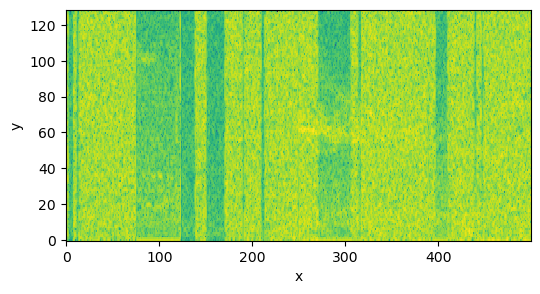

In [146]:
useful.vis_helper(out['noise_data'][0])

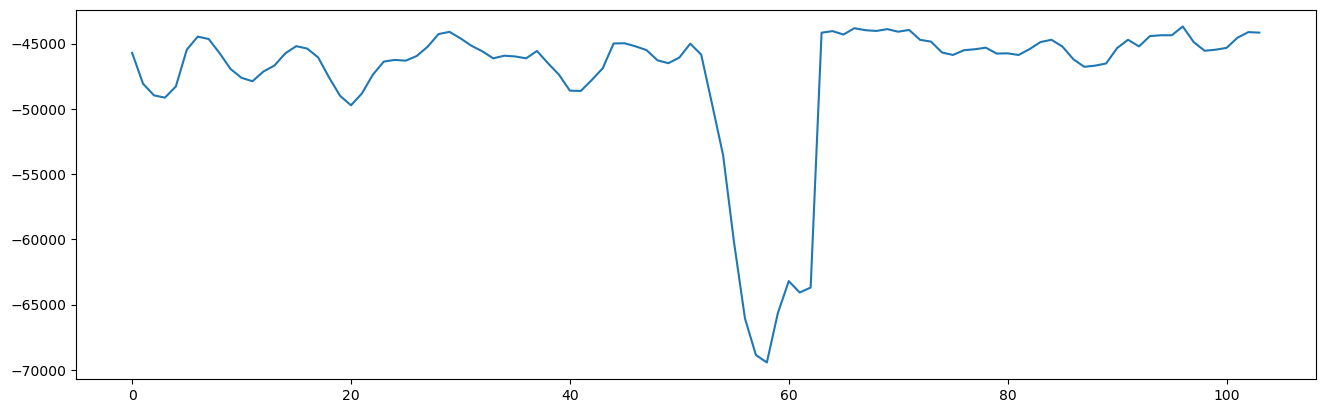

In [147]:
# close_test = np.isclose(windows_states, test_pred[:len(windows_states)])
plt.plot(out['prob'])

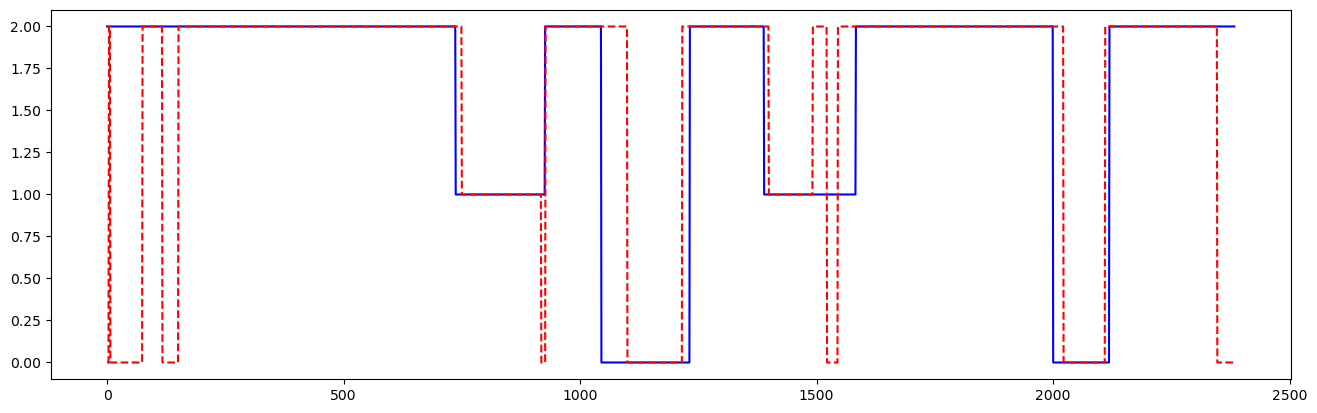

In [148]:
plt.plot(np.concatenate(test_new.feature_labels)[3000:], c='b')
plt.plot(useful.smooth_labels(windows_states[3000:]), '--', c='r')
# plt.plot(useful.smooth_labels(windows_states[3000:]), '--', c='g')

In [149]:
accuracy = useful.perf_measure(np.concatenate(test_new.feature_labels)[3000:], useful.smooth_labels(windows_states[3000:]))
print(accuracy)

{'ACC': 0.7265625, 'TPR': 0.5986238532110092, 'FPR': 0.0, 'TNR': 1.0, 'PPV': 1.0, 'NPV': 0.5382585751978892, 'FNR': 0.4013761467889908, 'FDR': 0.0}


In [150]:
# plot spectrogram showing models and given annots,
importlib.reload(useful)

label_to_abr = {
    0: 'H',
    1: 'B',
    2: 'N'
}

useful.plot_spectrogram(test_features_concat, np.concatenate(test.feature_labels), useful.smooth_labels(windows_states), label_to_type, label_to_abr)

ValueError: need at least one array to concatenate